# Estudio Experimental de Aprendizaje  Connect-4 
Este notebook documenta paso a paso cómo el agente evoluciona desde cero utilizando una combinación de búsqueda Monte Carlo (MCTS) y memoria reforzada (Reinforcement Learning).  
Se registran métricas clave como tasa de victorias, tamaño del conocimiento, tiempos de entrenamiento y test, así como gráficos que muestran cómo el agente aprende, optimiza y mejora su toma de decisiones a través de ciclos evolutivos.


**Pip necesarios**
Estos son los instaladores necesarios para ejecutar el Notebook

In [ ]:
!pip install numpy matplotlib pandas


[notice] A new release of pip is available: 24.3.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


## 1. Policy
A continuación se presenta la política utilizada por el agente durante los experimentos.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import time
import os
import sys
import pickle
import gzip

from groups.GroupA.policy import WinortzPolicy 
from groups.GroupB.policy import WinPolicy 

plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = [10, 6]


sys.path.append(os.getcwd())



def check_win_sim(b, p):
    
    for r in range(6):
        for c in range(4):
            if b[r,c]==p and b[r,c+1]==p and b[r,c+2]==p and b[r,c+3]==p: return True
    for c in range(7):
        for r in range(3):
            if b[r,c]==p and b[r+1,c]==p and b[r+2,c]==p and b[r+3,c]==p: return True
    for r in range(3):
        for c in range(4):
            if b[r,c]==p and b[r+1,c+1]==p and b[r+2,c+2]==p and b[r+3,c+3]==p: return True
            if b[r+3,c]==p and b[r+2,c+1]==p and b[r+1,c+2]==p and b[r,c+3]==p: return True
    return False

def play_match(agent1, agent2, time_limit=0.2):
    
    board = np.zeros((6, 7))
    player = 1
    moves = 0
    

    try: agent1.mount(time_limit)
    except: pass
    try: agent2.mount(time_limit)
    except: pass

    while True:
        current = agent1 if player == 1 else agent2
        try:
            action = current.act(board)
        except: return -player 
        
        # Aplicar
        for r in range(5, -1, -1):
            if board[r, action] == 0:
                board[r, action] = player
                break
        
        if check_win_sim(board, player): return player
        if moves >= 41: return 0
        
        player = -player
        moves += 1

## 2. Experimento de Evolución

Ejecutamos un ciclo de entrenamiento iterativo para demostrar cómo el agente mejora su desempeño mediante la acumulación de experiencia.

**Metodología:**
**Línea Base:** Medimos el desempeño con el cerebro vacío.
**Entrenamiento:** El agente juega contra el rival para llenar su memoria RAM.
**Optimización (Decay + Poda):** Aplicamos un factor de olvido (decay) para mantener la plasticidad y podamos estados poco visitados para eficiencia.
**Evaluación:** Medimos el Win Rate resultante.

In [ ]:
# CONFIGURACIÓN DEL EXPERIMENTO 
CYCLES = 4
TRAIN_GAMES = 30
TEST_GAMES = 20
TIME_LIMIT = 0.5

# 1. Inicializar Agentes
hero = WinortzPolicy()
hero.knowledge_base = {}
hero.knowledge_file = "demo_brain.pkl.gz"

try: rival = WinPolicy()
except: rival = WinortzPolicy()

history = {
    "cycle": [],
    "win_rate": [],
    "brain_size": [],
    "train_time": [],  
    "test_time": []     
}




start_test = time.time()    
wins = 0

for _ in range(TEST_GAMES):
    p1, p2 = (hero, rival) if _ % 2 == 0 else (rival, hero)
    res = play_match(p1, p2, time_limit=0.2)
    if (res == 1 and p1 == hero) or (res == -1 and p2 == hero):
        wins += 1

test_time = time.time() - start_test   
baseline_wr = (wins / TEST_GAMES) * 100
history["cycle"].append(0)
history["win_rate"].append(baseline_wr)
history["brain_size"].append(0)
history["train_time"].append(0)        
history["test_time"].append(test_time) 



# APRENDIZAJE

for cycle in range(1, CYCLES + 1):

    # A. ENTRENAMIENTO
    start_train = time.time()          

    for _ in range(TRAIN_GAMES):
        play_match(hero, rival, time_limit=TIME_LIMIT)

    train_time = time.time() - start_train   


    # B. OPTIMIZACIÓN (Decay + Poda)
    decay_factor = 0.5
    for k, v in hero.knowledge_base.items():
        v.visits = int(v.visits * decay_factor)
        v.wins = v.wins * decay_factor

    hero.save_smart_knowledge(min_visits=3, max_states=20000)
    curr_size = len(hero.knowledge_base)


    # C. EVALUACIÓN
    start_test = time.time()        
    wins = 0

    for _ in range(TEST_GAMES):
        p1, p2 = (hero, rival) if _ % 2 == 0 else (rival, hero)
        res = play_match(p1, p2, time_limit=0.2)
        if (res == 1 and p1 == hero) or (res == -1 and p2 == hero):
            wins += 1

    test_time = time.time() - start_test   


    wr = (wins / TEST_GAMES) * 100

    # Registrar
    history["cycle"].append(cycle)
    history["win_rate"].append(wr)
    history["brain_size"].append(curr_size)
    history["train_time"].append(train_time)  


**BLOQUE 1 — Evolución del rendimiento y crecimiento del cerebro**

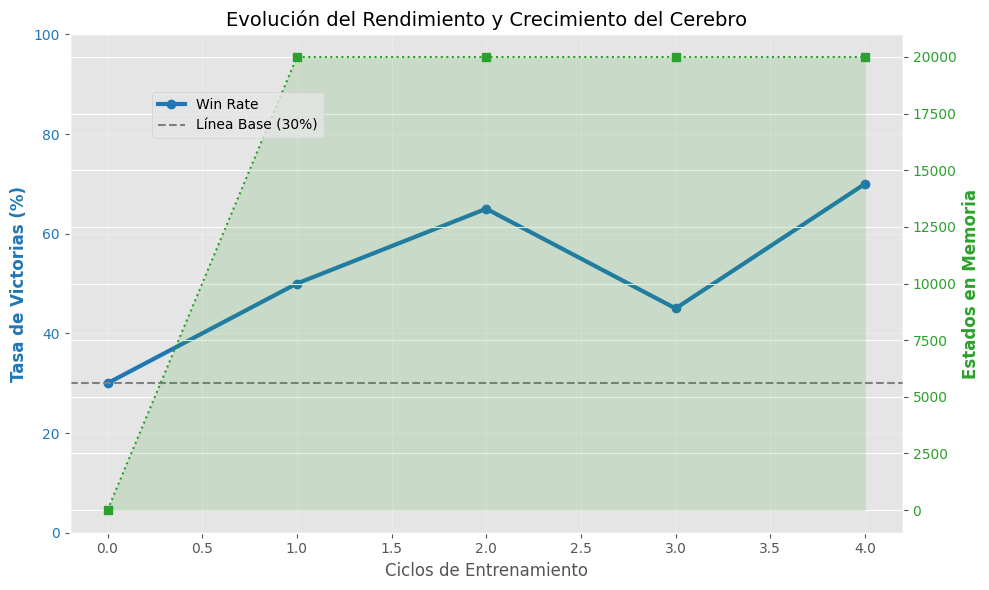

In [ ]:
# CRITERIO 1: Evolución del Rendimiento y Memoria
datos=  pd.DataFrame(history)
df_hist = datos[datos['cycle'] <= 4]
fig, ax1 = plt.subplots(figsize=(10, 6))

# Eje Y1: Tasa de Victorias
color = 'tab:blue'
ax1.set_xlabel('Ciclos de Entrenamiento')
ax1.set_ylabel('Tasa de Victorias (%)', color=color, fontweight='bold')
ax1.plot(df_hist['cycle'], df_hist['win_rate'], color=color, marker='o', linewidth=3, label='Win Rate')
ax1.tick_params(axis='y', labelcolor=color)
ax1.set_ylim(0, 100)
ax1.grid(True, alpha=0.3)

# Línea Base
ax1.axhline(y=baseline_wr, color='gray', linestyle='--', label=f'Línea Base ({baseline_wr:.0f}%)')

# Eje Y2: Tamaño del Cerebro
ax2 = ax1.twinx()
color = 'tab:green'
ax2.set_ylabel('Estados en Memoria', color=color, fontweight='bold')
ax2.fill_between(df_hist['cycle'], 0, df_hist['brain_size'], color=color, alpha=0.15)
ax2.plot(df_hist['cycle'], df_hist['brain_size'], color=color, linestyle=':', marker='s')
ax2.tick_params(axis='y', labelcolor=color)

plt.title('Evolución del Rendimiento y Crecimiento del Cerebro', fontsize=14)
fig.legend(loc="upper left", bbox_to_anchor=(0.15, 0.85))
fig.tight_layout()
plt.show()


**BLOQUE 2 — Tiempos de entrenamiento y test por ciclo**

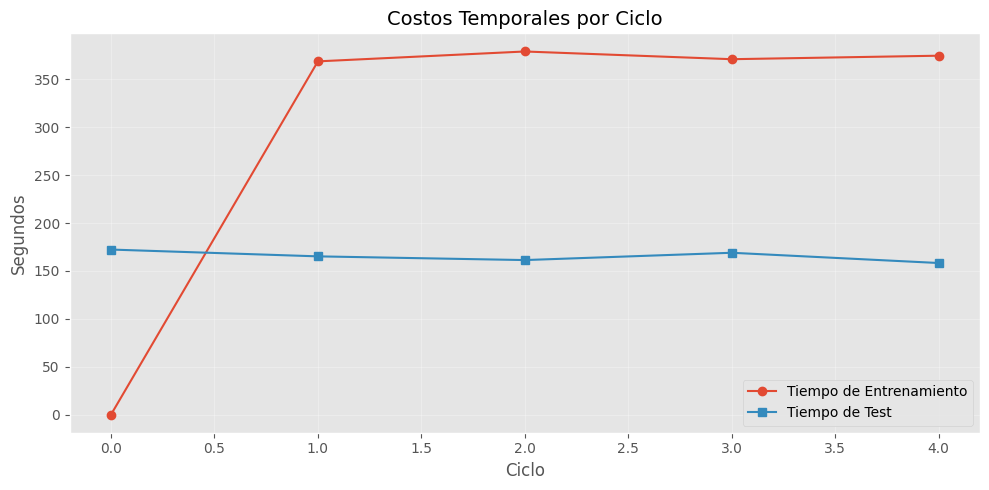

In [ ]:
# CRITERIO 2: Tiempos de Entrenamiento y Evaluación -
plt.figure(figsize=(10, 5))
plt.plot(df_hist['cycle'], df_hist['train_time'], marker='o', label='Tiempo de Entrenamiento')
plt.plot(df_hist['cycle'], df_hist['test_time'], marker='s', label='Tiempo de Test')

plt.title("Costos Temporales por Ciclo", fontsize=14)
plt.xlabel("Ciclo")
plt.ylabel("Segundos")
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()



**BLOQUE 3 — Eficiencia temporal del agente**

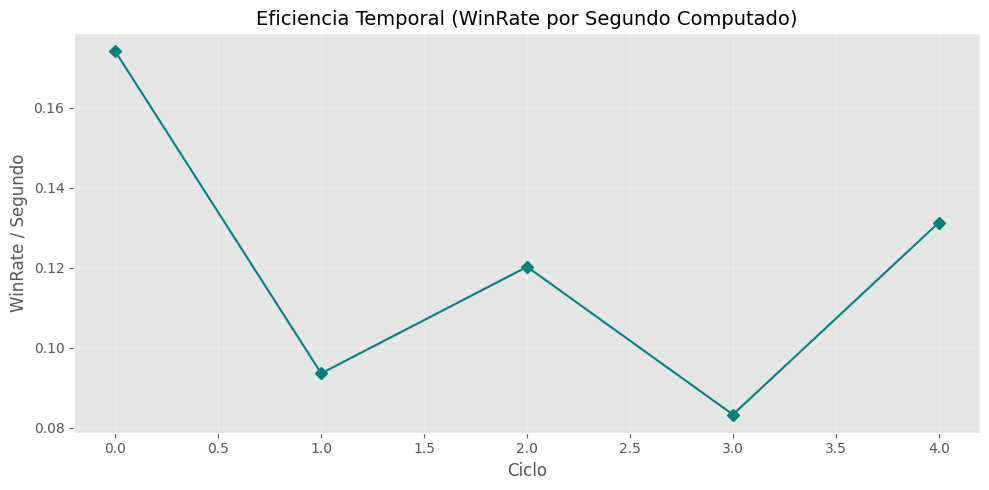

In [ ]:
# CRITERIO 4: Eficiencia Temporal
df_hist['eff_time'] = df_hist['win_rate'] / (df_hist['train_time'] + df_hist['test_time'] + 1e-9)

plt.figure(figsize=(10, 5))
plt.plot(df_hist['cycle'], df_hist['eff_time'], marker='D', color='teal')
plt.title("Eficiencia Temporal (WinRate por Segundo Computado)", fontsize=14)
plt.xlabel("Ciclo")
plt.ylabel("WinRate / Segundo")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


**BLOQUE 4 — Comparación MCTS puro vs MCTS+Memoria**

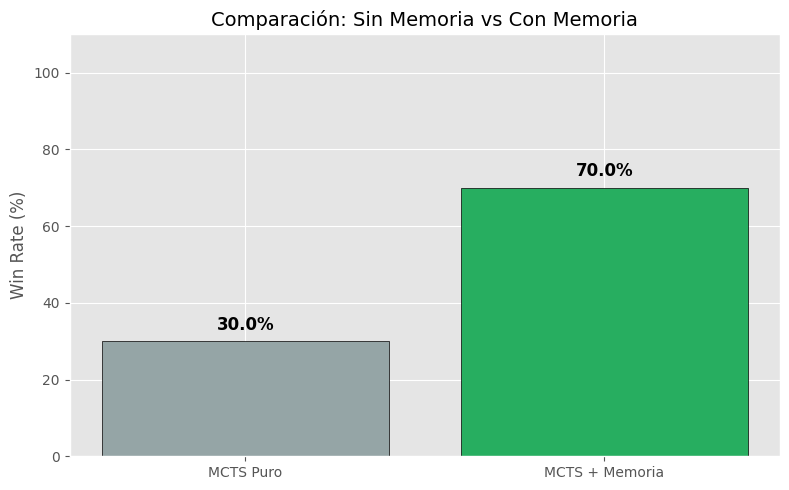

In [ ]:
# CRITERIO 4: Impacto de la Memoria
wr_start = df_hist.iloc[0]['win_rate']
wr_end = df_hist.iloc[-1]['win_rate']

plt.figure(figsize=(8, 5))
bars = plt.bar(
    ['MCTS Puro', 'MCTS + Memoria'],
    [wr_start, wr_end],
    color=['#95a5a6', '#27ae60'],
    edgecolor='black'
)

plt.title("Comparación: Sin Memoria vs Con Memoria", fontsize=14)
plt.ylabel("Win Rate (%)")
plt.ylim(0, 110)

for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 2,
             f'{height:.1f}%', ha='center', va='bottom', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()


**BLOQUE 5 — Curva suavizada del win-rate (rolling window)**

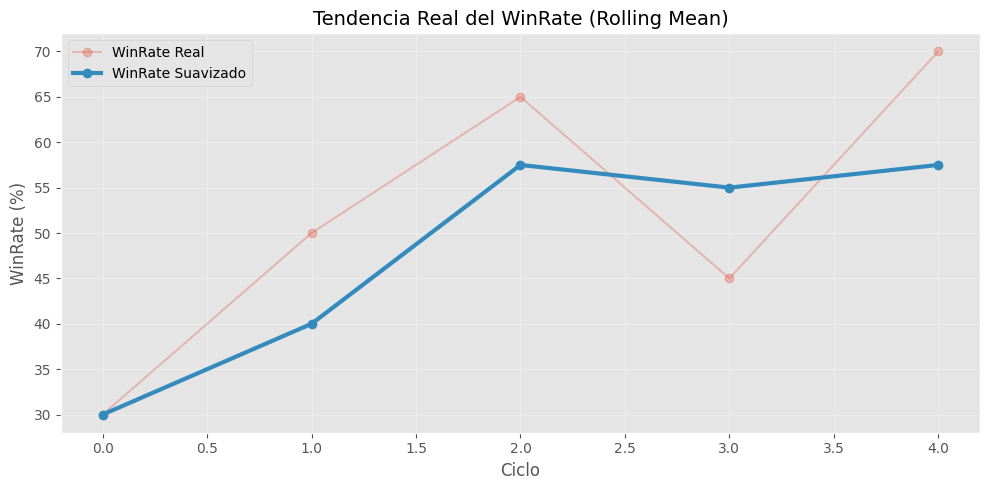

In [ ]:
# CRITERIO 5: Tendencia Suavizada del WinRate
df_hist['smooth_wr'] = df_hist['win_rate'].rolling(window=2, min_periods=1).mean()

plt.figure(figsize=(10, 5))
plt.plot(df_hist['cycle'], df_hist['win_rate'], marker='o', alpha=0.3, label="WinRate Real")
plt.plot(df_hist['cycle'], df_hist['smooth_wr'], marker='o', linewidth=3, label="WinRate Suavizado")

plt.title("Tendencia Real del WinRate (Rolling Mean)", fontsize=14)
plt.xlabel("Ciclo")
plt.ylabel("WinRate (%)")
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()


## 3. Validación de Estabilidad

Una vez entrenado el agente, realizamos una prueba de estrés de 50 partidas continuas sin aprendizaje (congelado). 

Generamos una curva de **Media Expansiva (Rolling Mean)**. Si la curva converge y se aplana por encima del 50%, demostramos que el agente es **robusto** y no depende de la suerte.

Ejecutando Test de Estabilidad (50 partidas)...


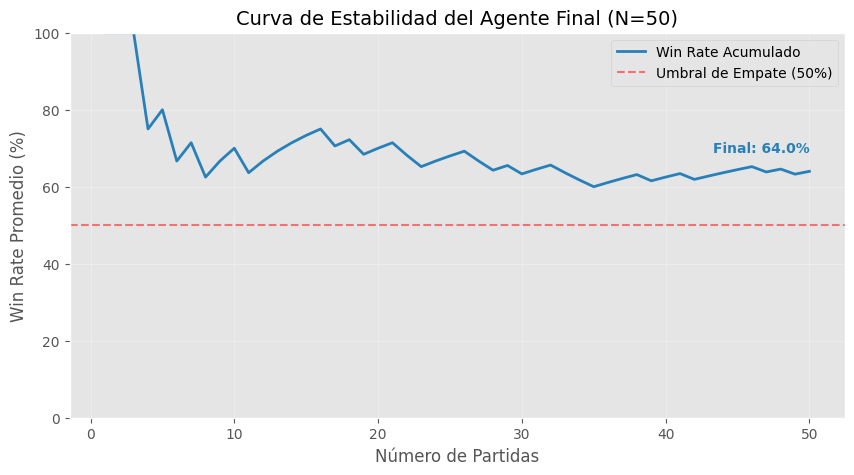

In [16]:
# TEST DE ESTABILIDAD (50 PARTIDAS)
print("Ejecutando Test de Estabilidad (50 partidas)...")

stability_history = []
wins_accum = 0

for i in range(1, 51):
    # Jugar partida
    p1, p2 = (hero, rival) if i % 2 == 0 else (rival, hero)
    res = play_match(p1, p2, time_limit=0.3) # Rápido
    
    # Registrar si Hero ganó (1) o no (0)
    is_win = 1 if (res == 1 and p1 == hero) or (res == -1 and p2 == hero) else 0
    
    wins_accum += is_win
    current_wr = (wins_accum / i) * 100
    stability_history.append(current_wr)

# --- GRAFICAR ---
plt.figure(figsize=(10, 5))
plt.plot(range(1, 51), stability_history, label="Win Rate Acumulado", color="#2980b9", linewidth=2)
plt.axhline(y=50, color='r', linestyle='--', alpha=0.5, label="Umbral de Empate (50%)")

plt.title(f"Curva de Estabilidad del Agente Final (N=50)", fontsize=14)
plt.xlabel("Número de Partidas")
plt.ylabel("Win Rate Promedio (%)")
plt.ylim(0, 100)
plt.legend()
plt.grid(True, alpha=0.3)

# Anotación del valor final
final_wr = stability_history[-1]
plt.text(50, final_wr + 5, f"Final: {final_wr:.1f}%", ha='right', fontweight='bold', color="#2980b9")
plt.show()